In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [2]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": [
        "Hi",
        "Hello",
        "Hey",
        "Good morning",
        "Good evening"
      ],
      "responses": [
        "Hello! How can I assist you today?",
        "Hi there! How can I help you?",
        "Hey! What can I do for you today?"
      ]
    },
    {
      "tag": "goodbye",
      "input": [
        "Bye",
        "Goodbye",
        "See you later",
        "Take care"
      ],
      "responses": [
        "Goodbye! Take care!",
        "See you later! Stay safe!",
        "Bye! Have a great day!"
      ]
    },
    {
      "tag": "thank_you",
      "input": [
        "Thank you",
        "Thanks",
        "I appreciate it",
        "Thanks a lot"
      ],
      "responses": [
        "You're welcome!",
        "No problem! I'm here to help.",
        "Anytime! Glad I could assist."
      ]
    },
    {
      "tag": "depression_help",
      "input": [
        "I feel depressed",
        "I need help with depression",
        "I'm feeling down",
        "I'm really sad",
        "Can you help me with depression?"
      ],
      "responses": [
        "I'm sorry to hear that you're feeling this way. There are several resources available to help with depression, such as therapy, support groups, and medication. Would you like more information on any of these?",
        "Depression can be very challenging, but there are ways to manage it. Have you considered talking to a therapist or joining a support group?",
        "It's important to talk to someone who can help. Would you like to know more about therapy options or other forms of support?"
      ]
    },
    {
      "tag": "therapy_options",
      "input": [
        "What therapy options are available?",
        "Tell me about therapy",
        "How can therapy help?",
        "Different types of therapy for depression"
      ],
      "responses": [
        "There are several types of therapy that can help with depression, including Cognitive Behavioral Therapy (CBT), Psychodynamic Therapy, and Interpersonal Therapy. Each type of therapy has its own approach and can be effective in different ways.",
        "Therapy options for depression include Cognitive Behavioral Therapy (CBT), which focuses on changing negative thought patterns, and Interpersonal Therapy, which focuses on improving relationships. Would you like more details on any specific type?",
        "Some common therapy options for depression are Cognitive Behavioral Therapy (CBT), which helps you manage your problems by changing the way you think and behave, and Psychodynamic Therapy, which involves talking about past experiences to understand current issues."
      ]
    },
    {
      "tag": "support_groups",
      "input": [
        "Tell me about support groups",
        "Are there any support groups for depression?",
        "How can support groups help?",
        "Depression support groups"
      ],
      "responses": [
        "Support groups can provide a sense of community and understanding, as you meet others who are going through similar experiences. They can be a great way to share coping strategies and feel less alone.",
        "There are many support groups available for people dealing with depression. These groups offer a safe space to talk about your feelings and connect with others who understand what you're going through.",
        "Support groups can help by providing emotional support and practical advice from others who have experienced depression. They can be found in person or online, and many people find them very beneficial."
      ]
    },
    {
      "tag": "medication",
      "input": [
        "Tell me about medication for depression",
        "Can medication help with depression?",
        "What medications are available for depression?",
        "Antidepressants"
      ],
      "responses": [
        "Medications, such as antidepressants, can be effective in managing depression for many people. They work by balancing chemicals in your brain that affect mood. It's important to consult with a healthcare provider to find the right medication for you.",
        "There are several types of medications available for treating depression, including SSRIs, SNRIs, and MAOIs. Each type works differently, and a healthcare provider can help determine which is best for you.",
        "Medication can be a helpful part of treatment for depression, often in combination with therapy. Common medications include SSRIs like Prozac and Zoloft, and SNRIs like Effexor and Cymbalta. Always consult a doctor before starting any medication."
      ]
    },
    {
      "tag": "self_care",
      "input": [
        "How can I take care of myself?",
        "Self-care tips for depression",
        "Ways to feel better",
        "Improving mood"
      ],
      "responses": [
        "Self-care is important when dealing with depression. Some helpful practices include regular exercise, maintaining a healthy diet, getting enough sleep, and engaging in activities you enjoy. Mindfulness and relaxation techniques can also be beneficial.",
        "Taking care of yourself can make a big difference. Try to stay physically active, eat balanced meals, get plenty of rest, and spend time with loved ones. It's also helpful to set small, manageable goals and celebrate your achievements.",
        "Self-care tips for managing depression include staying active, eating well, maintaining a regular sleep schedule, and practicing mindfulness or meditation. Finding hobbies or activities you enjoy can also help improve your mood."
      ]
    }
  ]
}

Writing content.json


In [3]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [4]:
#getting all data to lists
tags = []
inputs = []
responses = {}

for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for line in intent['input']:
    inputs.append(line)
    tags.append(intent['tag'])

In [5]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,"tags":tags})

In [6]:
#printing the data
data

,inputs,tags
0,Hi,greeting
1,Hello,greeting
2,Hey,greeting
3,Good morning,greeting
4,Good evening,greeting
5,Bye,goodbye
6,Goodbye,goodbye
7,See you later,goodbye
8,Take care,goodbye
9,Thank you,thank_you


In [7]:
data=data.sample(frac=1)

In [8]:
#preprocessing

#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd:''.join(wrd))
data

,inputs,tags
33,improving mood,self_care
23,are there any support groups for depression,support_groups
10,thanks,thank_you
28,what medications are available for depression,medication
14,i need help with depression,depression_help
29,antidepressants,medication
20,how can therapy help,therapy_options
11,i appreciate it,thank_you
7,see you later,goodbye
18,what therapy options are available,therapy_options


In [9]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train = le.fit_transform(data['tags'])


#Tensorflow's tokenizer assigns a unique token to each distinct word  and padding is done to get all the data to the same length so as to send it to an rnn layer

In [10]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [11]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words:",vocabulary)
output_length = len(le.classes_)
print("Output length:", output_length)

number of unique words: 60
Output length: 8


In [12]:
#creating the model

i = Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

In [13]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [14]:
#training the model
train=model.fit(x_train,y_train,epochs=300)

Epoch 1/300
2/2 [==============================] - 3s 18ms/step - loss: 2.0774 - accuracy: 0.2059
Epoch 2/300
2/2 [==============================] - 0s 14ms/step - loss: 2.0758 - accuracy: 0.1765
Epoch 3/300
2/2 [==============================] - 0s 18ms/step - loss: 2.0747 - accuracy: 0.2059
Epoch 4/300
2/2 [==============================] - 0s 14ms/step - loss: 2.0738 - accuracy: 0.2059
Epoch 5/300
2/2 [==============================] - 0s 14ms/step - loss: 2.0728 - accuracy: 0.3235
Epoch 6/300
2/2 [==============================] - 0s 13ms/step - loss: 2.0718 - accuracy: 0.2941
Epoch 7/300
2/2 [==============================] - 0s 13ms/step - loss: 2.0707 - accuracy: 0.2941
Epoch 8/300
2/2 [==============================] - 0s 13ms/step - loss: 2.0696 - accuracy: 0.2941
Epoch 9/300
2/2 [==============================] - 0s 14ms/step - loss: 2.0685 - accuracy: 0.2941
Epoch 10/300
2/2 [==============================] - 0s 20ms/step - loss: 2.0674 - accuracy: 0.2941
Epoch 11/300
2/2 [=

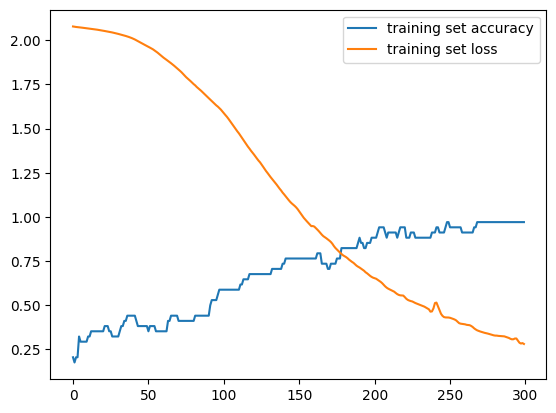

In [15]:
#model analysis
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [16]:
#Testing
import random

while True:
  texts_p = []
  prediction_input = input('You :')

  #removing punctuations and converting to lowercase
  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input=''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output=model.predict(prediction_input)
  output=output.argmax()

  #finding the right tag and predicting
  response_tag=le.inverse_transform([output])[0]
  print("CHATBOT:",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You :hi
1/1 [==============================] - 1s 1s/step
CHATBOT: Hey! What can I do for you today?
You :I feel depressed
1/1 [==============================] - 0s 26ms/step
CHATBOT: Depression can be very challenging, but there are ways to manage it. Have you considered talking to a therapist or joining a support group?
You :Tell me about therapy
1/1 [==============================] - 0s 29ms/step
CHATBOT: Therapy options for depression include Cognitive Behavioral Therapy (CBT), which focuses on changing negative thought patterns, and Interpersonal Therapy, which focuses on improving relationships. Would you like more details on any specific type?
You :How can i take care of myself
1/1 [==============================] - 0s 23ms/step
CHATBOT: Self-care is important when dealing with depression. Some helpful practices include regular exercise, maintaining a healthy diet, getting enough sleep, and engaging in activities you enjoy. Mindfulness and relaxation techniques can also be benef